### set folder_name and day session to analyze

In [302]:
name = 'ANM7'
session = '20240201_d3'

### imports

In [303]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [304]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscriminationData/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, arduino, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

respMTX shape: (130, 7)
MTXTrialType shape: (1000, 5)
number of trials: 130


In [305]:
open(leverdata_matfile)

<_io.TextIOWrapper name='../Data_Copy/LeverData/ANM7/LeverData_ANM7_20240201_d3.mat' mode='r' encoding='utf-8'>

For mac:

In [306]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240201_d3/: File exists


For windows:

In [307]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240201_d3/: File exists


preview trials

In [308]:
respMTX.shape

(130, 7)

In [309]:
respMTX_shape = respMTX.shape[0]
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(np.hstack((respMTX[1:respMTX_shape, 1:2]-respMTX[0:respMTX_shape-1, 1:2], np.array([np.linspace(0, respMTX_shape-2, respMTX_shape-1)]).transpose())))

[[21.415605 0.000000]
 [24.750049 1.000000]
 [23.583398 2.000000]
 [23.792180 3.000000]
 [21.714191 4.000000]
 [21.270490 5.000000]
 [21.504063 6.000000]
 [23.191661 7.000000]
 [20.833552 8.000000]
 [22.419571 9.000000]
 [23.597657 10.000000]
 [22.184100 11.000000]
 [25.086886 12.000000]
 [19.671491 13.000000]
 [15.804740 14.000000]
 [21.450125 15.000000]
 [24.984679 16.000000]
 [20.549199 17.000000]
 [21.635029 18.000000]
 [22.729304 19.000000]
 [22.711384 20.000000]
 [19.669397 21.000000]
 [23.232110 22.000000]
 [21.047605 23.000000]
 [23.253369 24.000000]
 [23.508258 25.000000]
 [15.748311 26.000000]
 [23.664921 27.000000]
 [21.985679 28.000000]
 [16.625850 29.000000]
 [23.634913 30.000000]
 [22.667373 31.000000]
 [24.681699 32.000000]
 [27.509533 33.000000]
 [21.883736 34.000000]
 [19.883851 35.000000]
 [22.223102 36.000000]
 [14.344453 37.000000]
 [13.162576 38.000000]
 [23.610698 39.000000]
 [14.571743 40.000000]
 [22.796577 41.000000]
 [23.873496 42.000000]
 [24.997418 43.000000

### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [310]:
!./preprocess_leverdata/leverdata2binary {output_folder} {leverdata_matfile} 72647

leverdata from .mat size: 72000000,72000000
leverdata from .mat rank: 2
leverdata vector size: 72000000
leverdata vector with unused rows taken out size: 17450713
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240201_d3/full.bin
finished a trialITI: 198417 index:0 trialITI length: 125770 samples = ~21s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240201_d3/trial0.bin
finished a trialITI: 343762 index:1 trialITI length: 145345 samples = ~24s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240201_d3/trial1.bin
finished a trialITI: 482257 index:2 trialITI length: 138495 samples = ~23s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240201_d3/trial2.bin
finished a trialITI: 621978 index:3 trialITI length: 139721 samples = ~23s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240201_d3/trial3.bin
finished a tri

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [311]:
num_trials = 129

### Look at sampling rates for the `lever_data`

In [312]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  21.415604599999998
Number of leverdata samples:  125770
Estimated freq:  5872.8204199287475
Trial  1
Duration in MATLAB seconds from respMTX:  24.750048500000005
Number of leverdata samples:  145345
Estimated freq:  5872.513744771044
Trial  2
Duration in MATLAB seconds from respMTX:  23.5833983
Number of leverdata samples:  138495
Estimated freq:  5872.563327737208
Trial  3
Duration in MATLAB seconds from respMTX:  23.792179899999994
Number of leverdata samples:  139721
Estimated freq:  5872.559832148883
Trial  4
Duration in MATLAB seconds from respMTX:  21.71419060000001
Number of leverdata samples:  127518
Estimated freq:  5872.565197065183
Trial  5
Duration in MATLAB seconds from respMTX:  21.270489799999993
Number of leverdata samples:  124912
Estimated freq:  5872.54930067478
Trial  6
Duration in MATLAB seconds from respMTX:  21.504062500000003
Number of leverdata samples:  126284
Estimated freq:  5872.564777004344


Trial  7
Duration in MATLAB seconds from respMTX:  23.191660799999994
Number of leverdata samples:  136194
Estimated freq:  5872.541909547074
Trial  8
Duration in MATLAB seconds from respMTX:  20.833551900000003
Number of leverdata samples:  122347
Estimated freq:  5872.594389437741
Trial  9
Duration in MATLAB seconds from respMTX:  22.419570899999997
Number of leverdata samples:  131660
Estimated freq:  5872.547721241178
Trial  10
Duration in MATLAB seconds from respMTX:  23.597656699999987
Number of leverdata samples:  138579
Estimated freq:  5872.574627293398
Trial  11
Duration in MATLAB seconds from respMTX:  22.184100400000034
Number of leverdata samples:  130277
Estimated freq:  5872.539235352532
Trial  12
Duration in MATLAB seconds from respMTX:  25.08688609999996
Number of leverdata samples:  147324
Estimated freq:  5872.550280363423
Trial  13
Duration in MATLAB seconds from respMTX:  19.671490900000038
Number of leverdata samples:  115523
Estimated freq:  5872.61029615197
Tria

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 40 Hz

Assuming electrical noise will be around 60 Hz

In [313]:
cutoff_frequency = 50
butterworth_filter_leverdata(output_folder, num_trials, cutoff_frequency)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [314]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [315]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [316]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

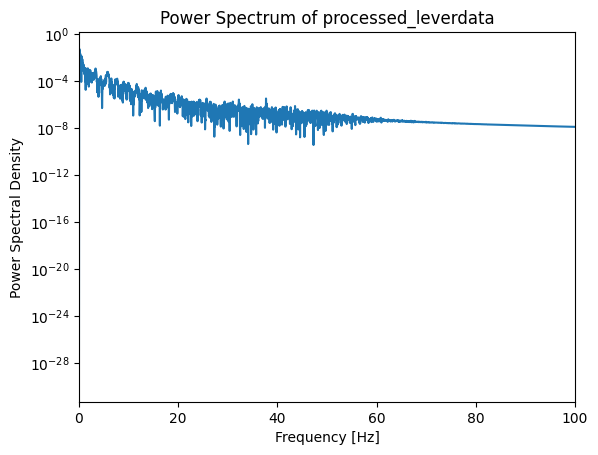

In [317]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)